# Numerical Methods: Coursework 2

I have used the shooting method to solve the bounday value problem. I used the shooting method because it is a fast algorithm and easy to code up. It's also accurate enough given to a tolerance for the methods used to solve the IVP and to root find $\phi(z)$. I have solved the IVP using a blackblock solver in scipy.integrate.odeint, which I believe uses Runge-Kutta methods. When converting from spherical polar to cartersian coords, I use the Euler stepping method due to it being easy to implement and accurate enough for it's purpose.

However, the solution is sensitive to the initial guess as a small change in the initial guess can drastically change the final solution.

For the case where wind is introduced, i.e. fx $\ne 0$, I compute the roots for $\phi(z)$ when there is no wind and then use these roots as initial guesses for when there is wind. This is because I am assuming the intial guesses for the solutions where there is wind will be very close to the solutions where there is no wind. This thus saves me from having to find suitable guesses for both the no-wind and wind cases.

In [1]:
import pytest
import numpy as np
import scipy as scp
from scipy import optimize
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import rcParams

rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16
rcParams['figure.figsize'] = (12, 12)

# =============================================================================
# Simulation Parameters
# =============================================================================

# parameters which are constant throughout

L = 4       # length of hair in cm
R = 10      # radius of head in cm
fg = 0.1    # force from gravity in cm ** -3


In [2]:
# =============================================================================
# Plotting Functions
# =============================================================================

def plot_on_circular_head(R, x_hair, z_hair, fg, fx):
    """
    Plot a circular head of radius R and plot the hair positions on the head.

    Parmeters
    ---------
    R: float.
        The radius of the head in units of cm.
    x_hair: n_hairs x n_points array of floats.
        The x coordinates of each hair.
    z_hair: n_hairs x n_points array of floats.
        the z coordinates of each hair.
    fg: float.
        The value of the force acting upon the hair due to gravity. In units of
        cm ** -3.
    fx: float.
        The value of the forced acting upon the hair due to wind in the
        positive x-direction. In units of

    Returns
    -------
    A plot showing the head and the positions of the hairs. Printed both to the
    console window and saved to the working directory.
    """

    # generate the coordinates where the hair will be placed, this will create
    # a semi-circle for the top half of the head. Plot -z for the bottom half
    # of the head, but don't plot hair as it doesn't grow here because we are
    # not modelling beards
    x = np.linspace(-R, R, 100)
    z = np.sqrt(-x ** 2 + R ** 2)

    n_hairs = x_hair.shape[0]

    fig = plt.figure()

    ax1 = fig.add_subplot(111)
    ax1.set_xlim(-R - 5, R + 5)
    ax1.set_ylim(-R - 5, R + 5)
    ax1.set_xlabel(r"$x$")
    ax1.set_ylabel(r"$z$")

    # plot the head by plotting two semi-circles
    ax1.plot(x, z, 'b-')
    ax1.plot(x, -z, 'b-')

    # plot the individual hairs, one at a time so I can plot as a line rather
    # than as x's or o's
    for hair in range(n_hairs):
        ax1.plot(x_hair[hair, :], z_hair[hair, :], '-')
        # no colour specification makes zany multi-coloured hair

    plt.gca().set_aspect('equal')
    fig.suptitle('fg = {} fx = {}'.format(fg, fx))
    plt.savefig('hair_phi=0__fg={}_fx={}.pdf'.format(fg, fx))
    plt.show()


def plot_on_circular_head_3d(R, x_hair, y_hair, z_hair, fg, fx):
    """
    Plot a circular head of radius R and plot the hair positions on the head.

    Parmeters
    ---------
    R: float.
        The radius of the head in units of cm.
    x_hair: n_hairs x n_points array of floats.
        The x coordinates of each hair.
    y_hair: n_hairs x n_points array of floats.
        The x coordinates of each hair.
    z_hair: n_hairs x n_points array of floats.
        the z coordinates of each hair.
    fg: float.
        The value of the force acting upon the hair due to gravity. In units of
        cm ** -3.
    fx: float.
        The value of the forced acting upon the hair due to wind in the
        positive x-direction. In units of

    Returns
    -------
    A plot showing the head and the positions of the hairs in the x, z and the
    y, z planes. Printed both to the console window and saved to the working
    directory.
    """

    # generate the coordinates where the hair will be placed, this will create
    # a semi-circle
    x = np.linspace(-R, R, 1000)
    y = np.linspace(-R, R, 1000)
    z = np.sqrt(-x ** 2 + R ** 2)

    n_hairs = x_hair.shape[0]

    fig = plt.figure(figsize=(15, 7.5))

    # subplot for x, z plane
    ax1 = fig.add_subplot(121)
    ax1.set_xlim(-R - 5, R + 5)
    ax1.set_ylim(-R - 5, R + 5)
    ax1.set_xlabel(r"$x$")
    ax1.set_ylabel(r"$z$")
    plt.gca().set_aspect('equal')
    # subplot for y, z plane
    ax2 = fig.add_subplot(122)
    ax2.set_xlim(-R - 5, R + 5)
    ax2.set_ylim(-R - 5, R + 5)
    ax2.set_xlabel(r"$y$")
    ax2.set_ylabel(r"$z$")
    plt.gca().set_aspect('equal')  # I seem to need to do this twice

    # plot a circle for the 2D head slice. No heads were harmed in the
    # making of these head slices
    ax1.plot(x, z, 'b-')
    ax1.plot(x, -z, 'b-')
    ax2.plot(y, z, 'b-')
    ax2.plot(y, -z, 'b-')

    # plot the individual hairs
    for hair in range(n_hairs):
        ax1.plot(x_hair[hair, :], z_hair[hair, :])
        ax2.plot(y_hair[hair, :], z_hair[hair, :])

    fig.suptitle('fg = {} fx = {}'.format(fg, fx))
    plt.savefig('hair_3d_slices_fg={}_fx={}.pdf'.format(fg, fx))
    plt.show()


def plot_on_sphereical_head(R, x_hair, y_hair, z_hair, fg, fx):
    """
    Plot a spherical head of radius R and plot the hair positions on the head.

    Parmeters
    ---------
    R: float.
        The radius of the head in units of cm.
    x_hair: n_hairs x n_points array of floats.
        The x coordinates of each hair.
    y_hair: n_hairs x n_points array of floats.
        The x coordinates of each hair.
    z_hair: n_hairs x n_points array of floats.
        the z coordinates of each hair.
    fg: float.
        The value of the force acting upon the hair due to gravity. In units of
        cm ** -3.
    fx: float.
        The value of the forced acting upon the hair due to wind in the
        positive x-direction. In units of

    Returns
    -------
    A plot showing the head and the positions of the hairs.Printed both to the
    console window and saved to the working directory.
    """

    n_hairs = x_hair.shape[0]

    # generate theta and phi values for a sphere
    theta = np.linspace(0, np.pi, 100)
    phi = np.linspace(0, 0.5 * np.pi, 100)

    # create a meshgrid of the theta and phi values
    THETA, PHI = np.meshgrid(theta, phi)

    # calculate the x, y, z coordinates for the sphere
    x = R * np.sin(PHI) * np.cos(THETA)
    y = R * np.sin(PHI) * np.sin(THETA)
    z = R * np.cos(PHI)

    fig = plt.figure(figsize=(12, 12))

    ax1 = fig.add_subplot(111, projection='3d')
    ax1.set_xlim(-R - 5, R + 5)
    ax1.set_ylim(-R - 5, R + 5)
    ax1.set_zlim(-R - 5, R + 5)
    ax1.set_xlabel(r'$x$')
    ax1.set_ylabel(r'$y$')
    ax1.set_zlabel(r'$z$')
    # ax1.view_init(elev=90, azim=90)  # use to plot top down
    plt.gca().set_aspect('equal')

    # plot the sphere using the carterisan coordinates
    # ax1.plot_surface(x, -y, z, alpha=1)  # this doesn't look correct

    # plot each hair individually so I can use a line instead of x's or o's
    for hair in range(n_hairs):
        ax1.scatter(x_hair[hair, :], y_hair[hair, :], z_hair[hair, :], '-',
                    linewidth=0.2)

    fig.suptitle('fg = {} fx = {}'.format(fg, fx))
    plt.savefig('hair_3d_fg={}, fx={}.pdf'.format(fg, fx))
    plt.show()

# 2D Problem

In [3]:
def shooting_2d(z, theta_0, boundary, fg, fx, n_points, root_return=False):
    """
    The shooting algorithm. Uses an initial guess z to integrate the IVP and
    then uses a rootfinding alogirthm to find the value of z. A grid is then
    generated and the IVP is integrated again using the guess [0, z_root]
    where z_root is the root of the function phi(z) to calculate the solution
    of the BVP.

    Parameters
    ----------
    z: float.
        The value of the initial guess for theta prime at s = 0.
    theta_0: 1 x n_hairs array of floats.
        The initial lattitude angle of each hair.
    boundary: 1 x 2 array of floats.
        An array containing the left hand side and right hand side boundary for
        the problem. Given in cartesian coordinates in units of cm.
    fg: float.
        The value of the force acting upon the hair due to gravity. In units of
        cm ** -3.
    fx: float.
        The value of the forced acting upon the hair due to wind in the
        positive x-direction. In units of
    n_points: float.
        The number of points to be used on the grid to integrate the IVP.
    root_return: boolean.
        If True, the function will only return the root to the function phi(z)
        defined in the function phi_z. If False (the default value), the
        function will return the grid spacing on the hair, ds, and the solution
        to the BVP.

    Returns
    -------
    h: float, if return_root = False.
        The value of the spacing on the grid used to integrate the IVP to find
        the solution to the BVP.
    bvp_sol: 1 x n_points array of floats, if return_root = False.
        The solution to the BVP for each points on the grid.
    z_root: float, if return_root = True.
        The root of phi(z), i.e. the value of the theta prime at s = 0.
    """

    def IVP(q, s):
        """
        Define the IVP q'(s). This is the IVP which will be integrated to find
        the solution theta(s).

        Parameters
        ----------
        q: 1 x 2 array of floats.
            The vector of initial values used to integrate the IVP.
        s: 1 x n_points array of floats.
            An array containing the grid positions used to integrate the IVP.

        Returns
        -------
        dq: 1 x 2 array of floats.
            The definition of the IVP.
        """
        
        assert(len(q) == 2), \
            'The initial guess needs to be of length 2.'

        dq = np.zeros_like(q)
        dq[0] = q[1]
        dq[1] = s * fg * np.cos(q[0]) + s * fx * np.sin(q[0])

        return dq

    def phi_z(z):
        """
        Defines the function phi(z) which takes in the intial guess of z and
        creates a residual function. Using rooting finding methods on this
        function will return an appropriate value of z to use in the intial
        guess vector when integrating the IVP to find theta(s).

        Parameters
        ----------
        z: float.
            The value of the initial guess for theta prime at s = 0.

        Returns
        -------
        phi: float.
            The value of phi(z) calculated for the current value of z. Use a
            root finding method to find the value of z such that phi(z) = 0 to
            solve the BVP.
        """
        
        assert(type(z) == float or np.float or int), \
            'Only one initial guess is needed.'
        
        ivp_int_sol = scp.integrate.odeint(IVP, [theta_0, z], boundary,
                                           full_output=1)

        # if the integration is not successful, then print that to the screen
        if ivp_int_sol[1]['message'] != 'Integration successful.':
            print(ivp_int_sol[1]['message'])

        # phi(z) = theta'(L, z) - L' = theta_2(L, z)
        bound = ivp_int_sol[0][-1, 1]
        phi = bound

        return phi

    def find_z(z_guess, phi):
        """
        Find the root of the function phi(z).

        Parameters
        ----------
        z_guess: float.
            The value of the initial guess for theta prime at s = 0.
        phi: function.
            The function to root find, i.e. phi(z).

        Returns
        -------
        z_root: float.
            The value of z which is the root of phi(z).
        """

        # make sure the guess is a number and not a list or anything else
        assert(type(z_guess) == float or np.float or int), \
            'Only one initial guess is needed.'
        
        z_root = scp.optimize.root(phi, z_guess).x

        return z_root
    
    assert(type(n_points) == int), \
        'The variable n_points must be an int.'
    if n_points <= 0:
        raise ValueError('The number of points for the hair grid must be more \
                         than zero.')

    # if reoot_return is True, return just the value of the root, i.e. the
    # value of theta prime at s = 0, of a hair
    if root_return is False:
        # returns the ds separation, h, and the theta solution on s
        z_root = find_z(z, phi_z)  # find the value of z to use for theta'(0)
        # create the integration grid and and find spacing on the grid
        s, h = np.linspace(boundary[0], boundary[1], n_points, retstep=True)
        # solve the bvp
        bvp_sol = scp.integrate.odeint(IVP, [theta_0, z_root], s)

        # return theta_1 as theta_1 = theta, i.e. the solution to the BVP
        return h, bvp_sol[:, 0]

    else:
        # returns the theta prime (s=0) value
        z_root = find_z(z, phi_z)

        return z_root


def euler_step_2d(ds, theta, x0, z0):
    """
    Compute an Euler step to determine the value of x, z at the next interval
    on the hair grid.

    Parameters
    ----------
    ds: float.
        The separation of the grid points used to integrate the IVP.
    theta: 1 x n_points array of floats.
        The value of theta at each point on the integration grid.
    x0: float.
        The x coordinate of the hair's initial position.
    z0: float.
        The z coordinate of the hair's initial position.

    Returns
    -------
    x, z: 1 x n_points array of floats.
        The location a hair on a cartesian grid.
    """

    # unlikely that ds will be zero, but check it anyway
    if ds <= 0:
        raise ValueError('The spacing on the integration grid has to be \
                         positive.')

    N = len(theta)
    xs = np.zeros(N)
    zs = np.zeros(N)

    # set the initial values for x and z
    xs[0] = x0
    zs[0] = z0

    # iterate through all the points on the grid to caculate the value of
    # x, z
    for i in range(N - 1):
        xs[i + 1] = xs[i] + ds * np.cos(theta[i])
        zs[i + 1] = zs[i] + ds * np.sin(theta[i])

    return xs, zs


def hair_locations_2d(L, R, fg, fx, theta_0):
    """
    Function to return the location of hairs on a head.

    Parameters
    ----------
    L: float.
        The size of each hair in units of cm.
    R: float.
        The radius of the head in units of cm.
    fg: float.
        The value of the force acting upon the hair due to gravity. In units of
        cm ** -3.
    fx: float.
        The value of the forced acting upon the hair due to wind in the
        positive x-direction. In units of
    theta_0: 1 x n_hairs array of floats.
        The initial lattitude angle of each hair.

    Returns
    -------
    x_coords, z_coords: n_hairs x n_points array of floats.
        The x, z coordinates of each hair.
    """

    if L <= 0:
        raise ValueError('The length of the hairs, L,  must be a positive \
                         value.')
    if R <= 0:
        raise ValueError('The size of the person\'s head, R, must be a \
                         positive value.')
    if fg <= 0:
        raise ValueError('The direction of gravity must be poistive and \
                         non-zero.')

    assert(len(theta_0) != 0), \
        'You must specify the location of at least one hair.'

    n_hairs = len(theta_0)
    n_points = 100     # number of points on hair's grid
    boundary = [0, L]  # boundary for a hair

    # the sign of the value of z needs to depend on the side of the head of
    # the hair is on
    z = 0.6
    z_guess = np.zeros_like(theta_0)
    # this makes one side of the head -z and the other +z
    z_guess[:n_hairs//2] = -z
    z_guess[n_hairs//2:] = z

    # use absolute value as -fx would be wind in the negative x direction
    if np.abs(fx) > 0:
        # if there is wind, use the root for the no wind case as the initial
        # guess for the wind case.
        print('Calculating initial guess values using no wind...')
        for hair in range(n_hairs):
            # return the solution for each hair with no wind
            z_no_wind = shooting_2d(
                z_guess[hair], theta_0[hair], boundary, fg, fx, n_points,
                root_return=True)
            # dumb hack to ensure the sign of the guess is correct for each 
            # side of the head
            if hair < n_hairs//2:
                z_guess[hair] = z_no_wind
            else:
                z_guess[hair] =  np.abs(z_no_wind)
            
        # take the mean value for each side of the head and use this as the
        # initial guess for each side of the head; this is a bit hacky :^)
        z_guess[:n_hairs//2] = np.mean(z_guess[:n_hairs//2])
        z_guess[n_hairs//2:] = np.mean(z_guess[n_hairs//2:])
            
    x_coords = np.zeros((n_hairs, n_points))
    z_coords = np.zeros((n_hairs, n_points))

    # go through each hair and shoot for a solution theta(s)
    for hair in range(n_hairs):
        # calculate ds (the grid spacing on the hair) and theta(s) for each
        # individual hair
        h, theta_hair = shooting_2d(
            z_guess[hair], theta_0[hair], boundary, fg, fx, n_points)

        # calculate the initial conditions for the x, z coords for the hair
        x_0 = R * np.cos(theta_0[hair])
        z_0 = R * np.sin(theta_0[hair])

        # call the Euler step to calculate the x, z coordinates of the hair
        x_coords[hair, :], z_coords[hair, :] = euler_step_2d(
                h, theta_hair, x_0, z_0)

    return x_coords, z_coords

## 2d tests

In [4]:
def test_euler_step_2d():
    """
    Test the euler_step_2d function.
    """
    
    test_theta = np.array([ 
    1.53938040,  1.56873942,  1.59809841,  1.62745701,  1.65681447])
    
    # set up some initial data using test data and then use the Euler
    # stepping function to solve the ODE 
    ds = 0.040404040404
    x0 = 10 * np.cos(test_theta[0])
    z0 = 10 * np.sin(test_theta[0])
    x, z = euler_step_2d(ds, test_theta, x0, z0)
    
    # test the function returns the expected errors with bad input
    with pytest.raises(ValueError):
        euler_step_2d(0, test_theta, x0, z0)
        euler_step_2d(-ds, test_theta, x0, z0)
   
    # check to see if the initial positions are correct in the solution
    # returned from euler_step_2d
    assert(x0 == x[0]), 'Initial $x$ value incorrect.'
    assert(z0 == z[0]), 'Initial $z$ value incorrect.'
    
    # painstakingly calculated the final x and z coord by hand in Excel
    # for the 5 thetas in test_theta. Compare them to what the function
    # is outptting.
    x_final = 0.312068
    z_final = 10.15658
    
    assert(np.isclose(x_final, x[-1])), 'x-coordinates calculated incorrectly.'
    assert(np.isclose(z_final, z[-1])), 'z-coordinates calculated incorrectly.'
    

def test_shooting_2d():
    """
    Test the shooting_2d function.
    """
    
    test_theta = 0  # this is a theta_0 value
    z = 0.6
    boundary =[0, 4]
    fg = 0.1
    fx = 0.1
    n_points = 5
    
    # test that bad input returns the correct errors
    with pytest.raises(ValueError):
        shooting_2d(z, test_theta, boundary, fg, fx, -1, 
                         root_return=True)
        shooting_2d(z, test_theta, boundary, fg, fx, 0, 
                         root_return=True)
    
    with pytest.raises(AssertionError):
        shooting_2d(z, test_theta, boundary, fg, fx, 1.5, 
                         root_return=True)
    
    # check to see if the root_return function is working correctly as this
    # is very important for models with wind
    
    # if this doesn't work, then the code will crash as it will  be returning
    # the integration grid separation and the solution to the BVP instead of
    # just the root of the phi(z). 
    
    # there should be one argument output then root_return = True, which will
    # be the roots of phi(z). When False, the number or agruments returned should
    # be 2
    assert(len(shooting_2d(z, test_theta, boundary, fg, fx, n_points, 
                         root_return=True)) == 1), \
        'Too many arguments returned with root_return = True'
    assert(len(shooting_2d(z, test_theta, boundary, fg, fx, n_points, 
                         root_return=False)) == 2), \
        'Not enough arguments returned with root_return = False'
    
    z_root = shooting_2d(z, test_theta, boundary, fg, fx, n_points, 
                         root_return=True)
    assert(np.isclose(z_root[0], 1.01439324)), \
        'The root for phi(z) for this value of theta_0 is not correct.'
    
    # test that the spacing of the integration grid is coming out correctly
    h, theta = shooting_2d(z, test_theta, boundary, fg, fx, n_points, 
                         root_return=False)
    dx = (boundary[1] - boundary[0])/(n_points - 1)
    assert(np.isclose(h, dx)), 'The grid spacing is incorrect.'
    
    # check the first element of theta is the boundary condition
    assert(theta[0] == test_theta), 'The initial value of theta is incorrect.'
    

def test_hair_locations_2d():
    """
    Test the hair_locations_2d function. The output of the function
    will not be tested and the output is controlled by the two other
    functions tested.
    """
    
    # define some constants
    L = 4
    R = 10
    fg = 0.1
    fx = 0.0
    n_hairs = 20 
    theta_0 = np.linspace(0, np.pi, n_hairs)
    
    # check the function returns errors for bad input
    with pytest.raises(ValueError):
        hair_locations_2d(0, R, fg, fx, theta_0)
        hair_locations_2d(-L, R, fg, fx, theta_0)
        hair_locations_2d(L, 0, fg, fx, theta_0)
        hair_locations_2d(L, -R, fg, fx, theta_0)
        hair_locations_2d(L, R, -fg, fx, theta_0)
    with pytest.raises(AssertionError):
        hair_locations_2d(L, R, fg, fx, [])
        
    # that's all folks!    

In [5]:
test_euler_step_2d()
test_shooting_2d()
test_hair_locations_2d()

In [6]:
# generate the theta 0 values
n_hairs = 20
assert(type(n_hairs) == int), 'The number of hairs needs to be an int.'
thetas = np.linspace(0, np.pi, n_hairs)

## No wind

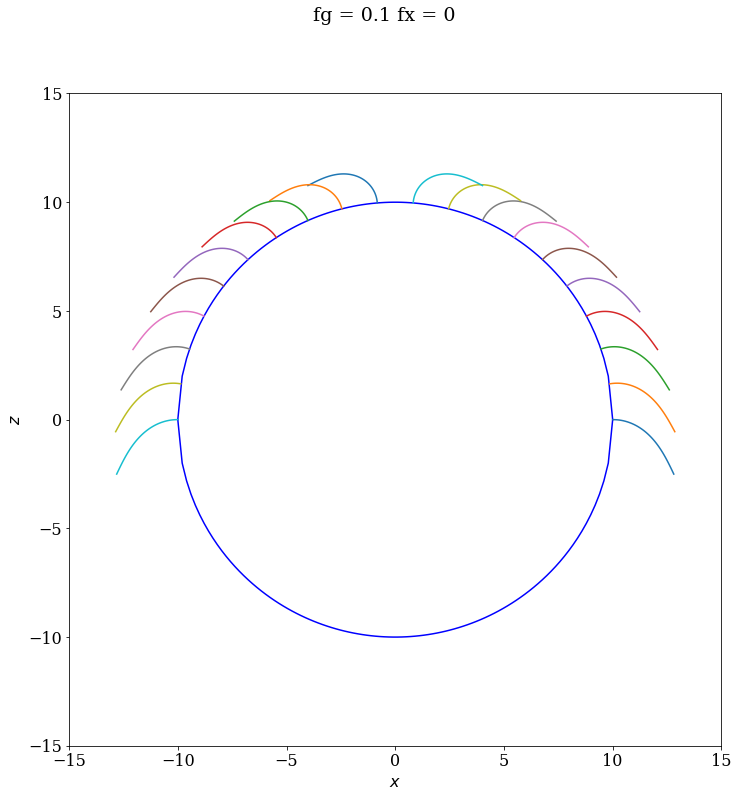

In [7]:
fx = 0  # no wind
x_coords, z_coords = hair_locations_2d(L, R, fg, fx, thetas)
plot_on_circular_head(R, x_coords, z_coords, fg, fx)

## Wind, fx = 0.1

Calculating initial guess values using no wind...


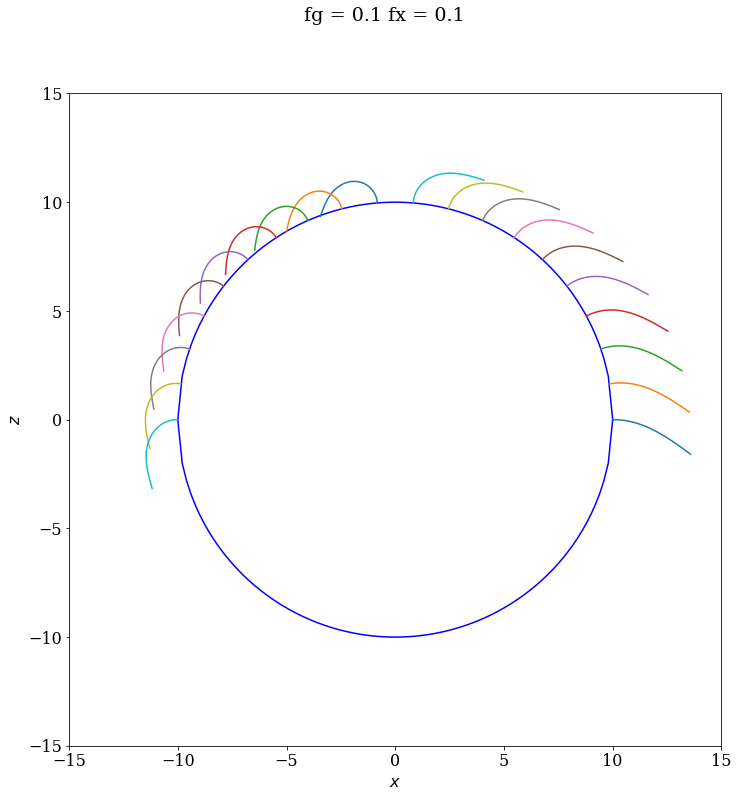

In [8]:
fx = 0.1  # introduce a bit of wind
x_coords, z_coords = hair_locations_2d(L, R, fg, fx, thetas)
plot_on_circular_head(R, x_coords, z_coords, fg, fx)

# 3D Problem

In [9]:
def shooting_3d(z, theta_0, phi_0, boundary, fg, fx, n_points,
                root_return=False):
    """
    The shooting algorithm. Uses an initial guess z to integrate the IVP and
    then uses a rootfinding alogirthm to find the value of z. A grid is then
    generated and the IVP is integrated again using the guess [0, z_root]
    where z_root is the root of the function phi(z) to calculate the solution
    of the BVP.

    Parameters
    ----------
    z: list of floats, [theta', phi'].
        The value of the initial guess for theta prime and phi prime
        at s = 0.
    theta_0: n x n array of floats, where n x n = n_hairs.
        The initial lattitude angle of each hair. Theta_0 needs to be part of a
        meshgrid of theta_0 and phi_0.
    phi_0: n x n array of floats, where n x n = n_hairs.
        The initial longitude angle of each hair. Phi_0 needs to be part of a
        meshgrid of theta_0 and phi_0.
    boundary: 1 x 2 array of floats.
        An array containing the left hand side and right hand side boundary for
        the problem. Given in cartesian coordinates in units of cm.
    fg: float.
        The value of the force acting upon the hair due to gravity. In units of
        cm ** -3.
    fx: float.
        The value of the forced acting upon the hair due to wind in the
        positive x-direction. In units of
    n_points: float.
        The number of points to be used on the grid to integrate the IVP.
    root_return: boolean.
        If True, the function will only return the root to the function phi(z)
        defined in the function phi_z. If False (the default value), the
        function will return the grid spacing on the hair, ds, and the solution
        to the BVP.

    Returns
    -------
    h: float, if return_root = False.
        The value of the spacing on the grid used to integrate the IVP to find
        the solution to the BVP.
    bvp_sol: 1 x n_points array of floats, if return_root = False.
        The solution to the BVP for each points on the grid for theta and phi
        separately.
    z_root: float, if return_root = True.
        The root of phi(z), i.e. the value of the theta prime at s = 0.
    """

    def IVP(q, s):
        """
        Define the IVP q'(s). This is the IVP which will be integrated to find
        the solution theta(s).
        
        Parameters
        ----------
        q: 1 x 4 array of floats.
            The vector of initial values used to integrate the IVP.
        s: 1 x n_points array of floats.
            An array containing the grid positions used to integrate the IVP.

        Returns
        -------
        dq: 1 x 4 array of floats.
            The definition of the IVP.
        """
        
        assert(len(q) == 4), \
            'The q vector needs to be of length 4.'
        
        dq = np.zeros_like(q)
        dq[0] = q[1]
        dq[1] = s * fg * np.cos(q[0]) + s * fx * np.cos(q[2]) * np.sin(q[0])
        dq[2] = q[3]
        dq[3] = - s * fx * np.sin(q[0]) * np.sin(q[2])
        
        return dq

    def phi_z(z):
        """
        Defines the function phi(z) which takes in the intial guess of z and
        creates a residual function. Using rooting finding methods on this
        function will return an appropriate value of z to use in the intial
        guess vector when integrating the IVP to find theta(s), phi(s).

        Parameters
        ----------
        z: list of floats, [theta', phi'].
            The value of the initial guess for theta prime and phi prime
            at s = 0.

        Returns
        -------
        phi: float.
            The value of phi(z) calculated for the current value of z. Use a
            root finding method to find the value of z such that phi(z) = 0 to
            solve the BVP.
        """
        
        assert(len(z) == 2), \
            'Two initial guesses are needed.'
        
        ivp_int_sol = scp.integrate.odeint(IVP, [theta_0, z[0], phi_0, z[1]],
                                           boundary, full_output=1)

        # if the integration is not successful, then print that to the screen
        if ivp_int_sol[1]['message'] != 'Integration successful.':
            print(ivp_int_sol[1]['message'])

        bounds = np.zeros(2)
        bounds[0] = ivp_int_sol[0][-1, 1]
        bounds[1] = ivp_int_sol[0][-1, 3]
        phi = bounds

        return phi

    def find_z(z_guess, phi):
        """
        Find the root of the function phi(z).

        Parameters
        ----------
        z: list of floats, [theta', phi'].
            The value of the initial guess for theta prime and phi prime
            at s = 0.
        phi: function.
            The function to root find, i.e. phi(z).

        Returns
        -------
        z_root: float.
            The value of z which is the root of phi(z).
        """
    
        assert(len(z_guess) == 2), \
            'Two initial guesses are needed.'

        z_root = scp.optimize.root(phi, z_guess).x

        return z_root
    
    assert(type(n_points) == int), \
        'The variable n_points must be an int.'
    if n_points <= 0:
        raise ValueError('The number of points for the hair grid must be more \
                         than zero.')

    # if reoot_return is True, return just the value of the root, i.e. the
    # value of theta prime at s = 0, of a hair
    if root_return is False:
        # returns the ds separation, h, and the theta solution on s
        z_root = find_z(z, phi_z)  # find the values of z to use
        # create the integration grid and and find spacing on the grid
        s, h = np.linspace(boundary[0], boundary[1], n_points, retstep=True)
        bvp_sol = scp.integrate.odeint(IVP, [theta_0, z_root[0], phi_0,
                                             z_root[1]], s)

        # return theta_1 and phi_1, i.e. theta and phi
        return h, bvp_sol[:, 0], bvp_sol[:, 2]

    else:
        # returns the theta', phi' at s = 0 value
        z_root = find_z(z, phi_z)

        return z_root


def euler_step_3d(ds, theta, phi, x0, y0, z0):
    """
    Compute an Euler step to determine the value of x, y, z at the next
    interval on the hair grid.

    Parameters
    ----------
    ds: float.
        The separation of the grid points used to integrate the IVP.
    theta: 1 x n_points array of floats.
        The value of theta at each point on the integration grid.
    x0: float.
        The x coordinate of the hair's initial position.
    y0: float.
        The y coordinate of the hair's initial position.
    z0: float.
        The z coordinate of the hair's initial position.

    Returns
    -------
    x, y, z: 1 x n_points array of floats.
        The location a hair on a cartesian grid.
    """

    # unlikely that ds will be zero, but check it anyway
    if ds <= 0:
        raise ValueError('The spacing on the integration grid has to be \
                         positive.')

    N = len(theta)
    xs = np.zeros(N)
    ys = np.zeros(N)
    zs = np.zeros(N)

    # set the initial values for x and z
    xs[0] = x0
    ys[0] = y0
    zs[0] = z0

    # iterate through all the points on the grid to caculate the value of
    # x, y, z
    for i in range(N-1):
        xs[i + 1] = xs[i] + ds * np.cos(theta[i]) * np.cos(phi[i])
        ys[i + 1] = ys[i] + ds * -np.cos(theta[i]) * np.sin(phi[i])
        zs[i + 1] = zs[i] + ds * np.sin(theta[i])

    return xs, ys, zs


def hair_locations_3d(L, R, fg, fx, theta_0, phi_0):
    """
    Function to return the location of hairs on a head.

    Parameters
    ----------
    L: float.
        The size of each hair in units of cm.
    R: float.
        The radius of the head in units of cm.
    fg: float.
        The value of the force acting upon the hair due to gravity. In units of
        cm ** -3.
    fx: float.
        The value of the forced acting upon the hair due to wind in the
        positive x-direction. In units of
    theta_0: n x n array of floats, where n x n = n_hairs.
        The initial lattitude angle of each hair. Theta_0 needs to be part of a
        meshgrid of theta_0 and phi_0.
    phi_0: n x n array of floats, where n x n = n_hairs.
        The initial longitude angle of each hair. Phi_0 needs to be part of a
        meshgrid of theta_0 and phi_0.

    Returns
    -------
    x_coords, y_coords, z_coords: n_hairs x n_points array of floats.
        The x, z coordinates of each hair.
    """

    if L <= 0:
        raise ValueError('The length of the hairs, L,  must be a positive \
                         value.')
    if R <= 0:
        raise ValueError('The size of the person\'s head, R, must be a \
                         positive value.')
    if fg <= 0:
        raise ValueError('The direction of gravity must be poistive and \
                         non-zero.')
    
    assert(len(theta_0) != 0), \
        'You must specify the location of at least one hair.'
    assert(len(phi_0) != 0), \
        'You must specify the location of at least one hair.'
        
    # the len of theta_0 and phi_0 can be different, i.e. if using a rectangle
    # grid of hair positions instead of a square grid

    n_grid_theta = theta_0.shape[0]
    n_grid_phi = phi_0.shape[0]
    n_hairs = n_grid_theta * n_grid_phi
    n_points = 100     # number of points on hair's grid
    boundary = [0, L]  # boundary for a hair

    # set up an array of initial guesses
    z_guess = np.zeros((2, n_grid_theta, n_grid_phi))
    z_guess[0, :, :] = -0.6
    z_guess[1, :, :] = 0

    if np.abs(fx) > 0:
        # if there is wind, use the root for the no wind case as the initial
        # guess for the wind case.
        print('Calculating initial guess values using no wind...')
        for i in range(n_grid_theta):
            for j in range(n_grid_phi):
                # create a list for the z guess at the location theta, phi
                z_guesses = [z_guess[0, i, j], z_guess[1, i, j]]
                z_no_wind = shooting_3d(
                    z_guesses, theta_0[i, j], phi_0[i, j], boundary, fg,
                    fx, n_points, root_return=True)
                z_guess[0, i, j] = z_no_wind[0]
                z_guess[1, i, j] = z_no_wind[1]
        
    x_coords = np.zeros((n_hairs, n_points))
    y_coords = np.zeros((n_hairs, n_points))
    z_coords = np.zeros((n_hairs, n_points))

    # go through each hair and shoot for a solution theta(s)
    hair = 0  # counter variable to track the hair we are on
    for i in range(n_grid_theta):
        for j in range(n_grid_phi):
            # create a list for the z guess at the location theta, phi
            z_guesses = [z_guess[0, i, j], z_guess[1, i, j]]
            # calculate the s and theta parameters for an individual hair
            h, theta_hair, phi_hair = shooting_3d(
                z_guesses, theta_0[i, j], phi_0[i, j], boundary, fg, fx,
                n_points)

            # calculate the initial conditions for the x, z coords
            x_0 = R * np.cos(theta_0[i, j]) * np.cos(phi_0[i, j])
            y_0 = - R * np.cos(theta_0[i, j]) * np.sin(phi_0[i, j])
            z_0 = R * np.sin(theta_0[i, j])

            # call the Euler step to calculate the x, z coordinates of the hair
            x_coords[hair, :], y_coords[hair, :], z_coords[hair, :] = \
                euler_step_3d(
                    h, theta_hair, phi_hair, x_0, y_0, z_0)

            # increment the hair counter, so it goes to the next hair on the
            # next loop of the grid
            hair += 1

    return x_coords, y_coords, z_coords

## 3d tests

In [10]:
def test_euler_step_3d():
    """
    Test the euler_step_3d function.
    """

    test_theta = np.array([
    1.53938040, 1.51002235, 1.48066474, 1.45130835, 1.42195435])
    test_phi = np.array([
    3.14159265, 3.14159265, 3.14159265, 3.14159265, 3.14159265])
    
    # set up some initial data using test data and then use the Euler
    # stepping function to solve the ODE 
    ds = 0.040404040404  # this ds probably isn't correct, but it works
    x0 = 10 * np.cos(test_theta[0]) * np.cos(test_phi[0])
    y0 = - 10 * np.cos(test_theta[0]) * np.sin(test_phi[0])
    z0 = 10 * np.sin(test_theta[0])
    x, y, z = euler_step_3d(ds, test_theta, test_phi, x0, y0, z0)
    
    # test the function returns the expected errors with bad input
    with pytest.raises(ValueError):
        euler_step_3d(0, test_theta, test_phi, x0, y0, z0)
        euler_step_3d(-ds, test_theta, test_phi, x0, y0, z0)
   
    # check to see if the initial positions are correct in the solution
    # returned from euler_step_2d
    assert(x0 == x[0]), 'Initial $x$ value incorrect.'
    assert(y0 == y[0]), 'Initial $x$ value incorrect.'
    assert(z0 == z[0]), 'Initial $z$ value incorrect.'
    
    # calculated values by hand. Compare with what the function outputs
    x_final = -0.326283
    y_final = 0
    z_final = 10.156135
    
    assert(np.isclose(x_final, x[-1])), 'x-coordinates calculated incorrectly.'
    assert(np.isclose(y_final, y[-1])), 'y-coordinates calculated incorrectly.'
    assert(np.isclose(z_final, z[-1])), 'z-coordinates calculated incorrectly.'
    

def test_shooting_3d():
    """
    Test the shooting_3d function.
    """
    
    test_theta = 0  # this is a theta_0 value
    test_phi = 0
    z = [0.6, 0]
    boundary =[0, 4]
    fg = 0.1
    fx = 0.1
    n_points = 5
    
    # test that bad input returns the correct errors
    with pytest.raises(ValueError):
        shooting_3d(z, test_theta, test_phi, boundary, fg, fx, -1, 
                         root_return=True)
        shooting_3d(z, test_theta, test_phi, boundary, fg, fx, 0, 
                         root_return=True)
    
    with pytest.raises(AssertionError):
        shooting_3d(z, test_theta, test_phi, boundary, fg, fx, 1.5, 
                         root_return=True)
    
    # check to see if the root_return function is working correctly as this
    # is very important for models with wind
    
    # if this doesn't work, then the code will crash as it will  be returning
    # the integration grid separation and the solution to the BVP instead of
    # just the root of the phi(z). 
    
    # there should be one argument output then root_return = True, which will
    # be the roots of phi(z). When False, the number or agruments returned should
    # be 2
    assert(len(shooting_3d(z, test_theta, test_phi, boundary, fg, fx, n_points, 
                         root_return=True)) == 2), \
        'Too many arguments returned with root_return = True'
    assert(len(shooting_3d(z, test_theta, test_phi, boundary, fg, fx, n_points, 
                         root_return=False)) == 3), \
        'Not enough arguments returned with root_return = False'
    
    z_root = shooting_3d(z, test_theta, test_phi, boundary, fg, fx, n_points, 
                         root_return=True)
    assert(np.isclose(z_root[0], 1.01394188)), \
       'The root for phi(z) for this value of theta_0 is not correct.'
    assert(np.isclose(z_root[1], 2.87822313e-04)), \
       'The root for phi(z) for this value of phi_0 is not correct.'
    
    # test that the spacing of the integration grid is coming out correctly
    h, theta, phi = shooting_3d(z, test_theta, test_phi, boundary, fg, fx, n_points, 
                         root_return=False)
    dx = (boundary[1] - boundary[0])/(n_points - 1)
    assert(np.isclose(h, dx)), 'The grid spacing is incorrect.'
    
    # check the first element of theta is the boundary condition
    assert(theta[0] == test_theta), 'The initial value of theta is incorrect.'
    assert(phi[0] == test_phi), 'The initial value of theta is incorrect.'

    
def test_hair_locations_3d():
    """
    Test the hair_locations_3d function. The output of the function
    will not be tested and the output is controlled by the two other
    functions tested.
    """
    
    L = 4
    R = 10
    fg = 0.1
    fx = 0.0
    n_hairs = 20 
    theta_0 = np.linspace(0, np.pi, n_hairs)
    phi_0 = np.linspace(0, np.pi, n_hairs)
    THETA, PHI = np.meshgrid(theta_0, phi_0)
    
    # check the function returns errors for bad input
    with pytest.raises(ValueError):
        hair_locations_3d(0, R, fg, fx, THETA, PHI)
        hair_locations_3d(-L, R, fg, fx, THETA, PHI)
        hair_locations_3d(L, 0, fg, fx, THETA, PHI)
        hair_locations_3d(L, -R, fg, fx, THETA, PHI)
        hair_locations_3d(L, R, -fg, fx, THETA, PHI)        
    with pytest.raises(AssertionError):
        hair_locations_3d(L, R, fg, fx, [], [])

    # that's all folks!

In [11]:
test_euler_step_3d()
test_shooting_3d()
test_hair_locations_3d()

In [12]:
# create the mesh grid of theta and phi positions for the hair locations
thetas = np.linspace(0, 0.49 * np.pi, 10)
phis = np.linspace(0, np.pi, 10)
THETA, PHI = np.meshgrid(thetas, phis)

## No wind

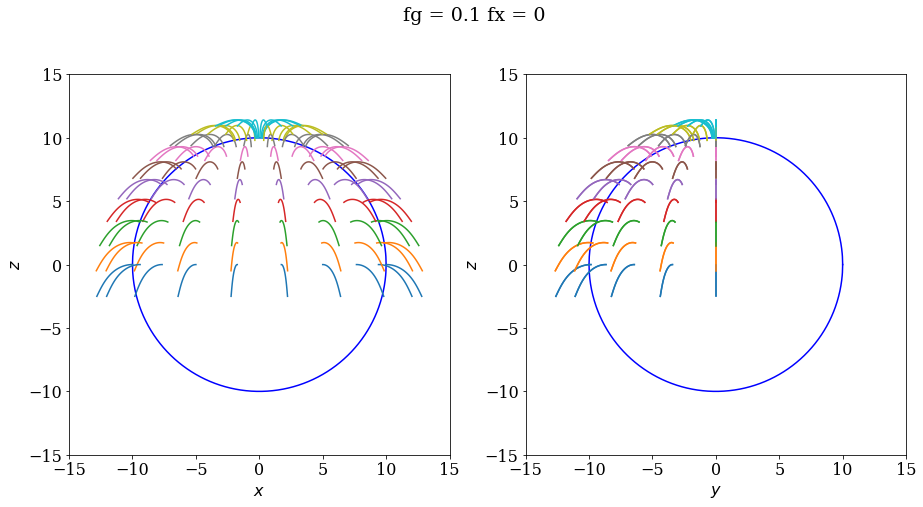

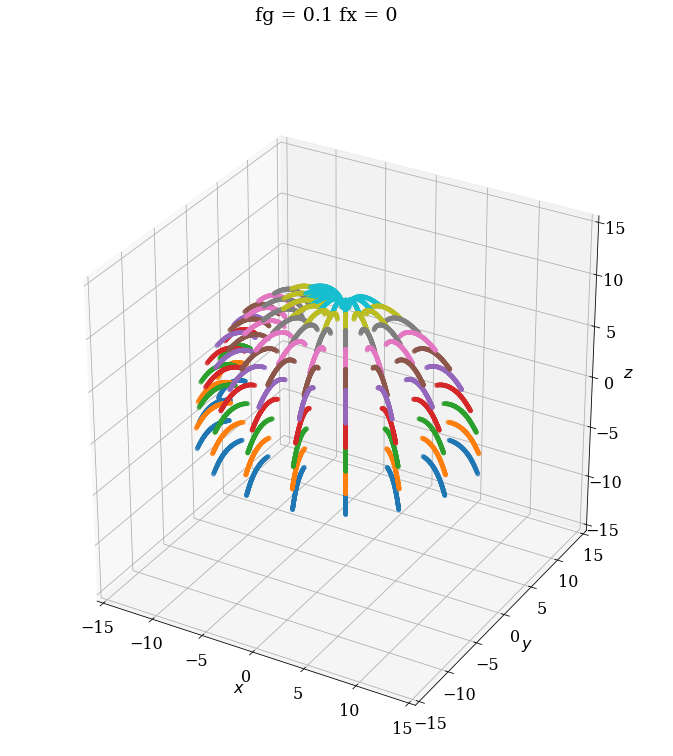

In [13]:
fx = 0  # use for testing purposes
x_coords, y_coords, z_coords = hair_locations_3d(L, R, fg, fx, THETA, PHI)
plot_on_circular_head_3d(R, x_coords, y_coords, z_coords, fg, fx)
plot_on_sphereical_head(R, x_coords, y_coords, z_coords, fg, fx)

## Wind, fx = 0.05

Calculating initial guess values using no wind...


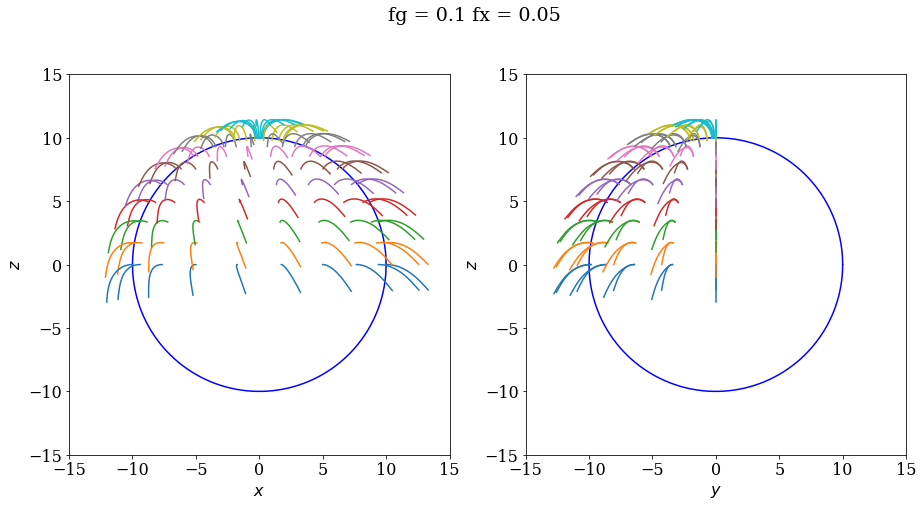

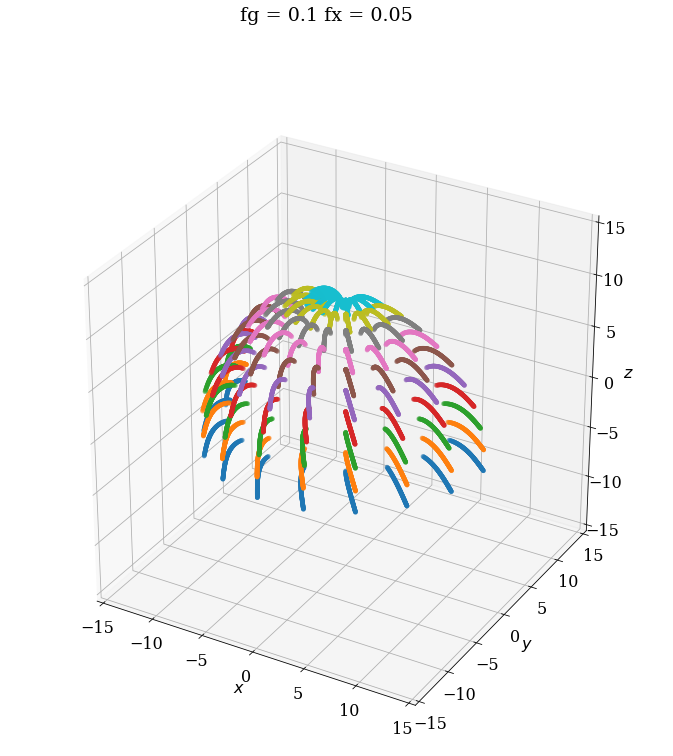

In [14]:
fx = 0.05  # just a little bit of wind
x_coords, y_coords, z_coords = hair_locations_3d(L, R, fg, fx, THETA, PHI)
plot_on_circular_head_3d(R, x_coords, y_coords, z_coords, fg, fx)
plot_on_sphereical_head(R, x_coords, y_coords, z_coords, fg, fx)